## Predicting Precipitation Type (Classifier)

#### *By: Heaton Chan, Rana Ghadymimahani, Amitaditya Paul, and Renee Choquette*

### Introduction:

One of the aspects that have a great impact on our day-to-day lives, yet that humans have very little control over, is the weather. Accurately predicting future weather has been a constant pursuit for many years, especially with the implications of global warming, which has been causing erratic changes to the climate. We believe that computer analysis is one of the most promising methods to achieve accurate weather predictions. In our project, we will be exploring a weather dataset to answer the following question: given the weather data in the United States, what type of precipitation (rain or snow) will occur. The original dataset contains weather data from different countries in the year 2020, but we chose to focus only on data from the United States (see Exploring Data for reasoning) and the following predictors: dew point, daily high temperature and daily low temperature. 

### Methods:

First, we loaded the packages needed to perform our analysis.

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(tidyr)
library(gridExtra)
library(rvest)
library(stringr)
library(infer)
library(knitr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

#### Read Data:
Then we loaded and read our data from a **REMOTE** source

In [3]:
url = "https://raw.githubusercontent.com/codingonapotato/dsci100_group_project_S2022/main/data/daily_weather_2020.csv"
download_weather <- download.file(url, destfile = "daily_weather_2020.csv")  # Object used to summon the file from the internet to the local machine

weather_data_raw <- suppressWarnings(read_csv("daily_weather_2020.csv")) %>%
                        select(-X1) %>% #Gets rid of the column keeping track of column numbers
                        rename("Country" = "Country/Region")

Parsed with column specification:
cols(
  .default = col_double(),
  `Country/Region` = col_character(),
  `Province/State` = col_character(),
  time = col_date(format = ""),
  summary = col_character(),
  icon = col_character(),
  precipType = col_character()
)

See spec(...) for full column specifications.



#### Exploring Data

We first explored our data by finding all of the columns in the dataframe and then determine how many rows belong to each country. From `count` we discovered that the US had the greatest amount of data in the dataset and will likely allow us to produce a more accurate classifier, thus we decided to filter our data to only contain data from the US.

In [4]:
names <- colnames(weather_data_raw) # So that we can see all the column names in the dataframe

count <- weather_data_raw %>%
            group_by(Country) %>%
            summarize(number_of_rows = n()) %>%
            arrange(desc(number_of_rows)) 
            #glimpse()    # !!! <Ask Nour if glimpse or non glimpse ver. matters for readability>    
            # So that we can see the rows of data we have to work with in each region  

weather_data_US_only <- weather_data_raw %>%
            select(Country, precipProbability, temperatureHigh, temperatureLow, dewPoint, precipType) %>%
            filter(Country == "US") # dataframe that only contains data from US  
weather_data_US_only

`summarise()` ungrouping output (override with `.groups` argument)



Country,precipProbability,temperatureHigh,temperatureLow,dewPoint,precipType
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
US,0.04,60.37,32.53,32.58,rain
US,0.07,61.00,47.42,30.54,rain
US,0.96,68.09,61.20,54.40,rain
US,0.98,63.40,54.90,61.56,rain
US,0.37,59.38,30.98,43.43,rain
US,0.06,60.45,35.99,30.59,rain
US,0.06,67.34,50.55,42.38,rain
US,0.12,62.47,31.89,37.19,rain
US,0.03,63.61,34.41,29.19,rain


#### Dropping `NA`'s and Final Tidy Data

We then wanted to explore how many of the rows in our data are blank (listed as `NA`) and filter these rows out to produce our final "clean" dataset (`weather_data`). We also included a table which summarizes the number of rows with all US data (including those with `NA`'s), how many of those rows contained missing values, and how many rows remain in the final tidy dataset.

In [5]:
na_count <- weather_data_US_only %>%
                filter(is.na(precipProbability) 
                       | is.na(temperatureHigh) 
                       | is.na(temperatureLow) 
                       | is.na(dewPoint) 
                       | is.na(precipType)) %>%
                nrow() # To show the amount of missing data in our variables

weather_data <- weather_data_US_only %>% 
    drop_na() %>%
    mutate(precipType = as.factor(precipType)) #dropping all NA values from the dataset and mutating precipType into a factor
 
unified_tibble <- slice(count, 1) %>%
                    mutate(number_of_missing_values = na_count) %>%
                    mutate(number_of_rows_final = nrow(weather_data))
unified_tibble #Aggregate table for column number and number of *previously missing values in the dataset that got removed

class_count <- weather_data %>%
                select(precipType) %>%
                count(precipType)
class_count # Formally show the amount of each label we have in our tidy dataset... use to justify the need to upscale data (mention that in methodology for sure)
# Gonna go ahead and add the upscaling step to the recipe (like 5.9 of the textbook does)


Country,number_of_rows,number_of_missing_values,number_of_rows_final
<chr>,<int>,<int>,<int>
US,6272,26,6246


precipType,n
<fct>,<int>
rain,4344
snow,1902


#### Splitting Data 

We then split our original dataset into a training set (50% of original data) and a testing set (other 50% of original data).
**MAY REQUIRE CHANGE HERE**

In [6]:
weather_recipe <- recipe(precipType ~ dewPoint + temperatureLow + temperatureHigh + precipProbability, data = weather_data) %>%
    step_upsample(precipType, over_ratio = 1, skip = FALSE) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) # NOTE: ok so I added precipProbability to recipe because otherwise upscaled data won't contain that
                                  # column, and we need that column for our exploratory analysis below  - Rana

upsampled_weather_data <- weather_recipe %>% 
                            prep() %>% 
                            bake(weather_data)

class_count_upsampled <- upsampled_weather_data %>%
                            select(precipType) %>%
                            count(precipType)
class_count_upsampled # Formally shows whether labels got upsampled successfully (looks like a yes to me!)

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


precipType,n
<fct>,<int>
rain,4344
snow,4344


In [7]:
set.seed(2022)

weather_split <- upsampled_weather_data %>%
                initial_split(prop = 0.6, strata = precipType) #!!! Not actually 50% here so either above markdown needs to be edited or code needs to be

weather_training <- training(weather_split) #training dataset

weather_testing <- testing(weather_split) #testing dataset

data_proportions <-  tibble(proportion_of_total_in_training = (nrow(weather_training)/nrow(upsampled_weather_data))) %>%
                        mutate(proportion_of_total_in_testing = (nrow(weather_testing)/nrow(upsampled_weather_data)))
data_proportions # To formally show the percentage of the tidy dataset that went into the training and testing datasets

precipType_props <- weather_training %>%
    group_by(precipType) %>%
    summarize(n = n()) %>%
    mutate(prop = n/nrow(weather_training))
precipType_props # Just to confirm whether labels are still upsampled after splitting data into training and testing sets

proportion_of_total_in_training,proportion_of_total_in_testing
<dbl>,<dbl>
0.6001381,0.3998619


`summarise()` ungrouping output (override with `.groups` argument)



precipType,n,prop
<fct>,<int>,<dbl>
rain,2607,0.5
snow,2607,0.5


#### Choosing and Visualizing Predictors

We then explored our data by calculating the mean dew point, probability of precipitation, daily high temperature, and daily low temperature.  In addition, we plotted our 3 predictors vs. probability of precipitation to visualize our data. From these visualizations, which all show a clear split between snow and rain precipitation types, we concluded that `dewPoint`, `temperatureHigh`, and `temperatureLow` have an effect on precipitation type. To confirm our choice of predictors, we also conducted some research which concluded that 

n,mean_dewPoint,mean_temperatureLow,mean_temperatureHigh,mean_precipProbability
<int>,<dbl>,<dbl>,<dbl>,<dbl>
5214,0.01285838,0.008580209,0.007115288,0.01902125


TableGrob (2 x 2) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]

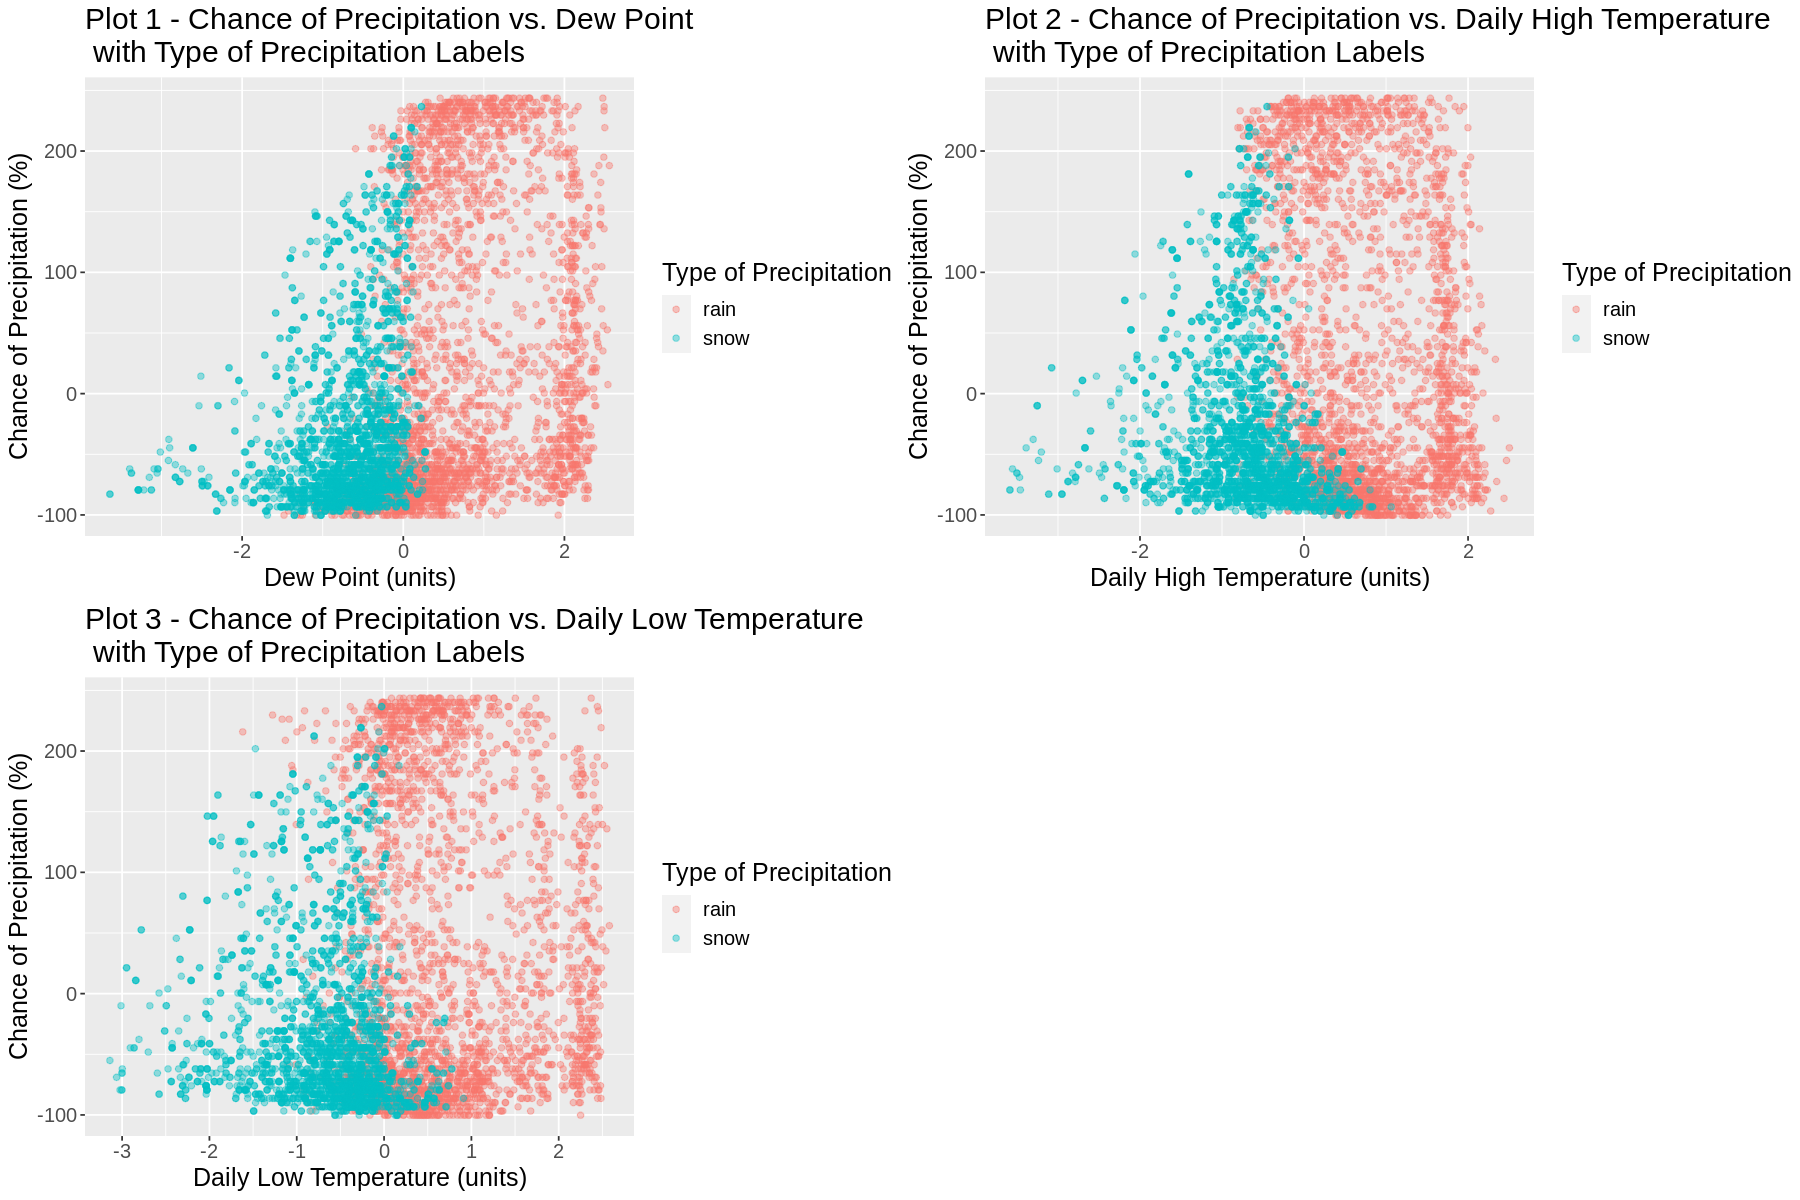

In [8]:
weather_train_means <- weather_training %>%
                            select(-precipType) %>%
                            map_df(mean) %>%
                            rename(mean_dewPoint = dewPoint,
                                  mean_precipProbability = precipProbability,
                                  mean_temperatureHigh = temperatureHigh,
                                  mean_temperatureLow = temperatureLow) #computed means for across all columns

weather_train_total <- tibble(n = nrow(weather_training)) #total number of rows for training data

weather_train_aggregate <- weather_train_total %>%
                                bind_cols(weather_train_means) #aggregated summary tables for the training data 
weather_train_aggregate

# possibly use the means as a MEANS (haha) to justify scaling the data? (i mean other than the fact that its standard practice for k-nn)

options(repr.plot.width = 15, repr.plot.height = 10)
plot1 <- weather_training %>%
                        mutate(precipProbability = precipProbability*100) %>%
                        ggplot(aes(x = dewPoint, y = precipProbability)) +
                        geom_point(aes(colour = precipType), alpha = 0.4) +
                        labs(x = "Dew Point (units)", y = "Chance of Precipitation (%)", colour = "Type of Precipitation") +
                        theme(text = element_text(size = 15)) +
                        ggtitle("Plot 1 - Chance of Precipitation vs. Dew Point \n with Type of Precipitation Labels")

plot2 <- weather_training %>%
                        mutate(precipProbability = precipProbability*100) %>%
                        ggplot(aes(x = temperatureHigh, y = precipProbability)) +
                        geom_point(aes(colour = precipType), alpha = 0.4) +
                        labs(x = "Daily High Temperature (units)", y = "Chance of Precipitation (%)", colour = "Type of Precipitation") +
                        theme(text = element_text(size = 15)) +
                        ggtitle("Plot 2 - Chance of Precipitation vs. Daily High Temperature \n with Type of Precipitation Labels")
plot3 <- weather_training %>%
                        mutate(precipProbability = precipProbability*100) %>%
                        ggplot(aes(x = temperatureLow, y = precipProbability)) +
                        geom_point(aes(colour = precipType), alpha = 0.4) +
                        labs(x = "Daily Low Temperature (units)", y = "Chance of Precipitation (%)", colour = "Type of Precipitation") +
                        theme(text = element_text(size = 15)) +
                        ggtitle("Plot 3 - Chance of Precipitation vs. Daily Low Temperature \n with Type of Precipitation Labels")

plots_together <- grid.arrange(plot1, plot2, plot3, ncol = 2)
plots_together

#### Finding the Best K-value

**NOT COMPLETELY DONE TUNING YET**

precipType,n
<fct>,<int>
rain,250
snow,250


[1] 21

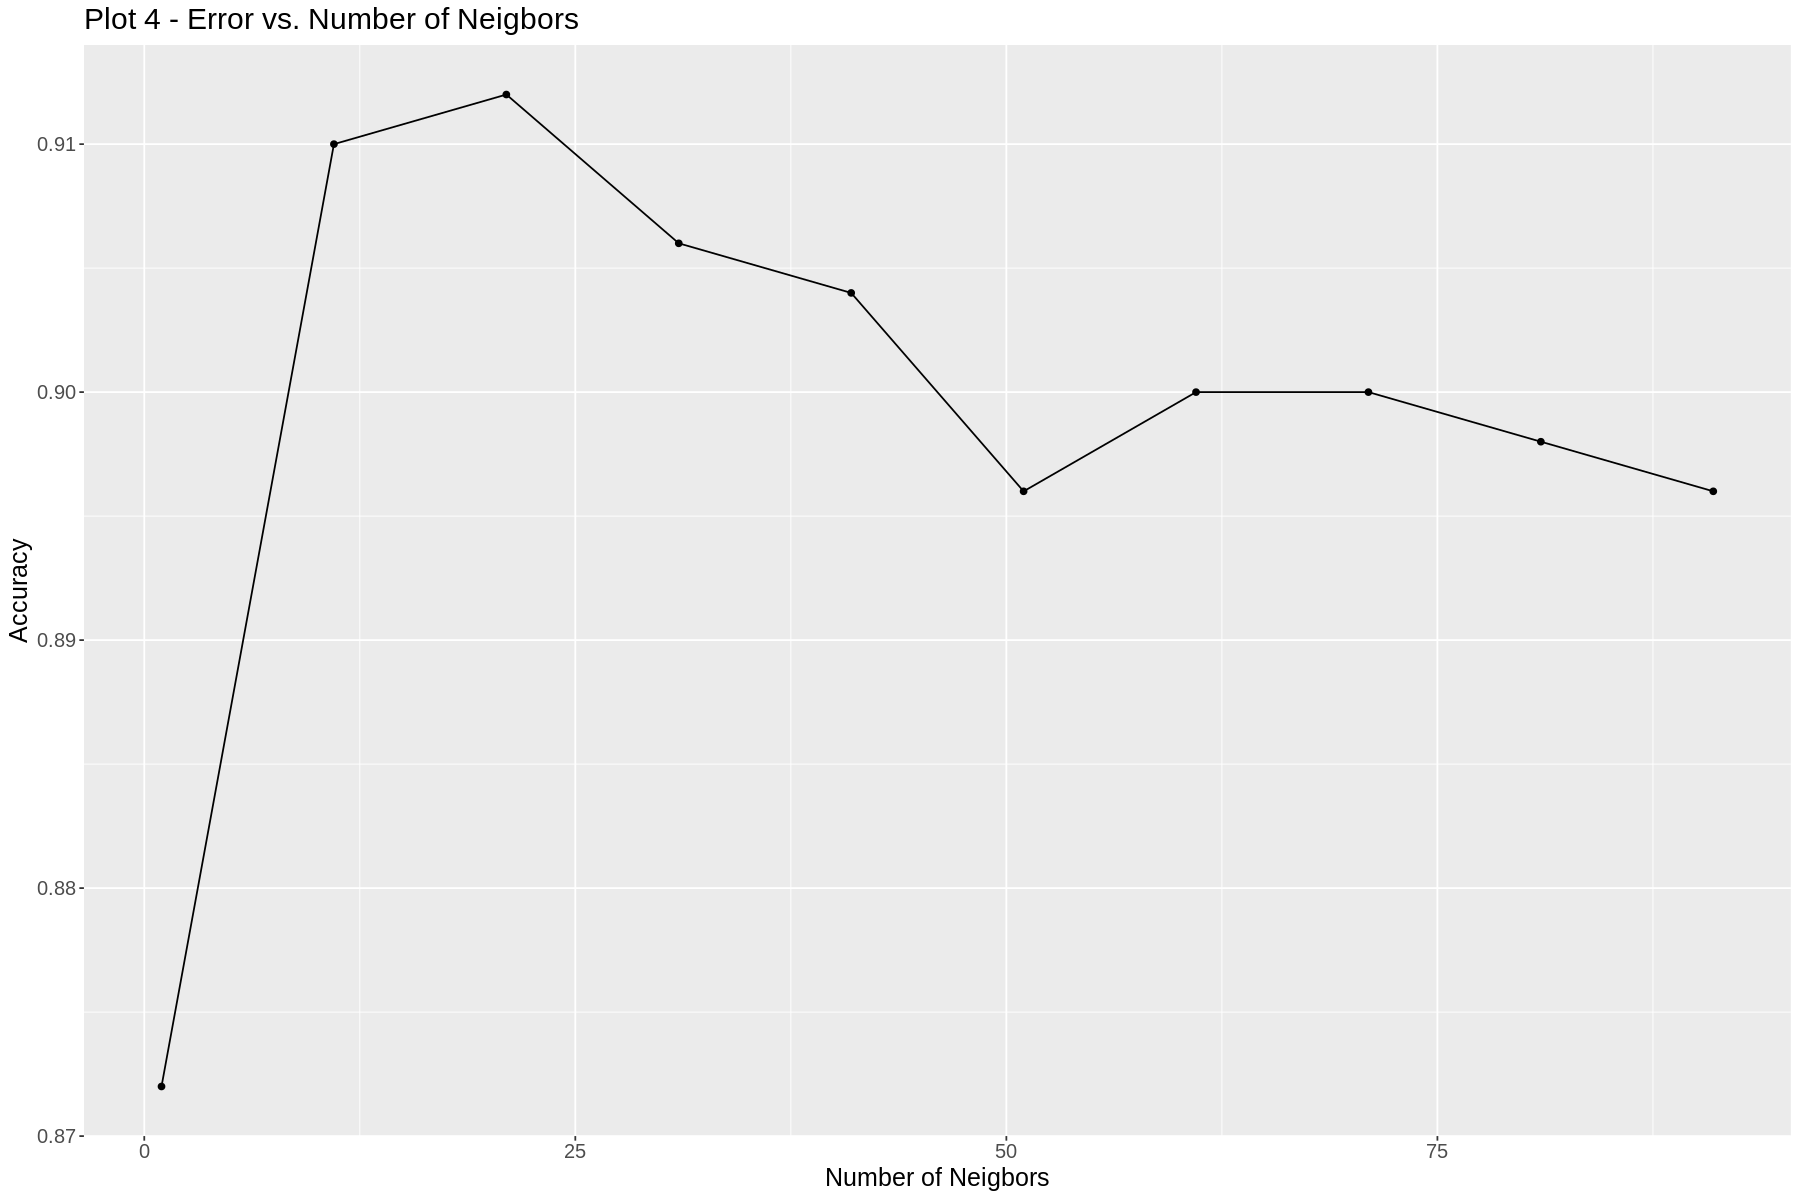

In [31]:
#---------------> DONT RUN THIS CELL CAUSE IT TAKES ALMOST A MINUTE TO RUN <--------------------
set.seed(2022)

#!!! Removed the weather_recipe from here moved it up to the above cell for testing purposes uhhh feel free to move it back or keep it in a new cell 
weather_train_sample <- weather_training %>%
    group_by(precipType) %>%
    sample_n(size = 250)

class_count_sample <- weather_train_sample %>%
                            select(precipType) %>%
                            count(precipType)
class_count_sample # Based on this table, we see that the proportion of precipType is not kept at a perfect 50-50 after taking a random sample

weather_recipe2 <- recipe(precipType ~ dewPoint + temperatureLow + temperatureHigh, data = weather_train_sample) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 

#weather_recipe3 <- recipe(precipType ~ dewPoint + temperatureLow + temperatureHigh, data = weather_train_sample) %>%
#    step_upsample(precipType, over_ratio = 1, skip = FALSE)

#upsampled_weather_sample <- weather_recipe3 %>% 
#                            prep() %>% 
#                            bake(weather_train_sample)

#class_count_upscaled_sample <- upsampled_weather_sample %>%
#                            select(precipType) %>%
#                            count(precipType)
#class_count_upscaled_sample

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification')

weather_vfold <- vfold_cv(weather_train_sample, v = 5, strata = precipType) 

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 10))

number_of_neighbors_stats <- workflow() %>%
    add_recipe(weather_recipe2) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = weather_vfold, grid = k_vals) %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

options(repr.plot.width = 15, repr.plot.height = 10)
number_of_neighbors_plot <- ggplot(number_of_neighbors_stats, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neigbors", y = "Accuracy",
        title = "Plot 4 - Error vs. Number of Neigbors") +
    theme(text = element_text(size = 15))

number_of_neighbors_plot

best_k_value <- number_of_neighbors_stats %>%
    arrange(by = desc(mean)) %>%
    slice(1) %>%
    select(neighbors) %>%
    pull()
best_k_value

#### Coding the Classifier & RMSE Calculation

$RMSE = 0.926$

In [32]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_value) %>%
    set_engine('kknn') %>%
    set_mode('classification')

knn_fit <- workflow() %>%
    add_recipe(weather_recipe2) %>%
    add_model(knn_spec) %>%
    fit(data = weather_training)

weather_accuracy <- predict(knn_fit, weather_training) %>%
    bind_cols(weather_training) %>%
    metrics(truth = precipType, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    pull()
weather_accuracy

[1] 0.9186805

### Methods (COPIED FROM PROPOSAL):

Our goal is to predict what type of precipitation (rain or snow) will occur based on the following variables; dew point, daily high temperature, daily low temperature, humidity, pressure, and probability of precipitation, with a focus on the US region. We chose the above variables because our exploratory data analysis plots showed a clear split between snow and rain precipitation types when plotted, thus we believe that they all have an effect on the type of precipitation. We will do this by splitting our original dataset into a training set (75% of original data) and a testing set (25% of original). We will then use the training data set to train our classifier to predict the type of precipitation using a K-nearest neighbor model. Prior to building our model, we will perform a cross-fold analysis to obtain a K-value with the highest accuracy. Next, we will run our classifier on our testing set and measure how accurately it performed. Finally, we will use those results to graph the proportion of data points our classifier predicted correctly and incorrectly. We will use a bar plot to produce such a visualization, as bar plots are preferred when visualizing proportions in data. We may also graph scatter plots of our different predictors to visualize trends in our data. Furthermore, we have provided an example of a precipitation probability vs. dew point graph above, but this data set provides many variables that we can measure and explore, to increase the accuracy of our prediction. 

### Expected outcomes and significance (COPIED FROM PROPOSAL):

We expect to find the precipitation type in the US, based on past data on humidity levels, daily low and high temperatures, pressure, dew points, and probability of precipitation. We chose the US as our focal country because it has the greatest amount of data in the dataset and will likely allow us to produce a more accurate classifier. The goal of predicting the type of precipitation is to provide information that people and organizations can use to reduce weather-related losses and enhance societal benefits. This includes protecting life and property, public health and safety, and support of economic prosperity and quality of life, as well as alerting businesses that rely on the weather (like farming or fishing), warning drivers to be cautious on the roads with certain weather conditions, to notify people how they should dress to stay safe and warm. Another question our findings may lead to is, when will each type of precipitation occur and in what amounts.
